  ### Notebook Summary – Experiment 1: RoBERTa

This notebook fine-tunes the roberta-base model for multi-label emotion classification using tweets labeled with 11 emotions.

The dataset is cleaned, tokenized using the RoBERTa tokenizer, and formatted into a Hugging Face Dataset for training and validation.

Class imbalance is handled using computed pos_weight values and a custom loss function (BCEWithLogitsLoss).

A subclassed Trainer is used to apply the weighted loss and track training progress using Weights & Biases (W&B).

The model is trained for 3 epochs, and predictions are made on the test set using a 0.5 threshold for binary classification.

The submission file is saved in the required Kaggle format with ID and 11 emotion columns.

In this experiment, we fine-tune the roberta-base model on a multi-label emotion classification dataset provided through our class Kaggle competition. The goal is to evaluate RoBERTa’s performance as a full-sized encoder-only transformer model and compare its effectiveness against lighter models such as DistilBERT and alternatives like ALBERT.

## Objective

Fine-tune the roberta-base model on the provided multi-label emotion classification dataset.

Evaluate the model’s performance using the competition metric (e.g., F1-score).

Log training progress and results using Weights & Biases (W&B).

Generate and submit predictions to Kaggle for evaluation.

Looking in indexes: https://download.pytorch.org/whl/cu118


## Environment Setup

In [ ]:
# Install core packages with their specific versions
# Make sure NumPy is installed correctly first
!pip install numpy==1.26.0 --force-reinstall

# Install tokenizers before transformers (since transformers depends on it)
!pip uninstall -y tokenizers
!pip install tokenizers==0.19.0

# Install transformers with the specific compatible version
!pip uninstall -y transformers
!pip install transformers==4.37.2

# Install peft with the specific compatible version (make sure to remove any existing versions)
!pip uninstall -y peft
!pip install peft==0.10.0

# Install accelerate which is needed for some transformers functionality
!pip install accelerate==0.26.0 --quiet

# Install evaluation and dataset packages
!pip install --no-cache-dir evaluate==0.4.3
!pip install datasets==3.5.0

#  Install visualization and other utilities
!pip install wordcloud==1.9.4
!pip install wandb
!pip install sentence-transformers==3.4.1
!pip install numba==0.60.0

#  Install common dependencies if needed
!pip install filelock pyarrow dill pandas requests tqdm xxhash multiprocess fsspec aiohttp huggingface-hub pyyaml pillow matplotlib typing-extensions charset-normalizer idna urllib3 certifi python-dateutil pytz tzdata contourpy cycler fonttools kiwisolver packaging pyparsing six


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 81.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
Found existing installation: tokenizers 0.21.1
Uninstalling tokenizers-0.21.1:
  Successfully uninstalled tokenizers-0.21.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 50.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 4.51.3 requires tokenizers<0.22,>=0.21

Found existing installation: peft 0.14.0
Uninstalling peft-0.14.0:
  Successfully uninstalled peft-0.14.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.5 MB/s eta 0:00:00
  Attempting uni

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.7/270.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 373.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 381.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 361.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 399.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
sente

In [ ]:

# Step 5: Verify installations
!pip list | grep numpy
!pip list | grep transformers
!pip list | grep peft
!pip list | grep evaluate
!pip list | grep tokenizers

# Step 6: Import and test key packages
import numpy as np
print("\nNumPy version:", np.__version__)
print("Does NumPy have 'dtypes'?", hasattr(np, 'dtypes'))

import transformers
print("Transformers version:", transformers.__version__)

try:
    from transformers import (
        DistilBertTokenizerFast,
        DistilBertForSequenceClassification,
        Trainer,
        TrainingArguments,
    )
    print("All transformer components imported successfully!")
except Exception as e:
    print("Error importing transformer components:", e)




numpy                                 1.26.0
sentence-transformers                 3.4.1
transformers                          4.51.3
peft                                  0.10.0
evaluate                              0.4.3
tokenizers                            0.21.1

NumPy version: 1.26.0
Does NumPy have 'dtypes'? True
Transformers version: 4.51.3
All transformer components imported successfully!


In [ ]:
# Test importing evaluate
import evaluate
print("\nEvaluate Details:")
print("Evaluate version:", evaluate.__version__)


Evaluate Details:
Evaluate version: 0.4.3


In [ ]:
# Verify transformers installation
import transformers
print("Transformers version:", transformers.__version__)

Transformers version: 4.51.3


In [ ]:
# Final verification - import key packages
import numpy as np
import transformers
import datasets
import evaluate
import wordcloud

print("\nFinal verification:")
print("NumPy version:", np.__version__)
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("Evaluate version:", evaluate.__version__)
print("WordCloud version:", wordcloud.__version__)


Final verification:
NumPy version: 1.26.0
Transformers version: 4.51.3
Datasets version: 3.5.0
Evaluate version: 0.4.3
WordCloud version: 1.9.4


In [ ]:
import torch
import numpy as np
import transformers
import datasets
import evaluate
import wordcloud

import pandas as pd
import numpy as np
import torch
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

from sklearn.model_selection import train_test_split
import evaluate
import wandb
import os
import seaborn as sns


# Standard libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import TrainingArguments
import seaborn as sns




In [ ]:
print("NumPy version:", np.__version__)
print("Does NumPy have 'dtypes'?", hasattr(np, 'dtypes'))
print("PyTorch version:", torch.__version__)
print("Transformers version:", transformers.__version__)
print("Datasets version:", datasets.__version__)
print("Evaluate version:", evaluate.__version__)
print("WordCloud version:", wordcloud.__version__)

NumPy version: 1.26.0
Does NumPy have 'dtypes'? True
PyTorch version: 2.6.0+cu124
Transformers version: 4.51.3
Datasets version: 3.5.0
Evaluate version: 0.4.3
WordCloud version: 1.9.4


In [ ]:
# Hugging Face libraries
from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments,
)

# Scikit-learn
from sklearn.model_selection import train_test_split

# Evaluation and logging
import evaluate
import wandb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# System utilities
import os

print("All imports successful!")

All imports successful!


In [ ]:
# Check if GPU is available
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA available: True
GPU device name: Tesla T4


In [ ]:
# Optional: Store your W&B API key (only needed if you're not logged in via Colab UI)
wandb_api_key = '137b014a91f75b1c495116229423e9f47fe8605a'

# Safely login if API key is available
if wandb_api_key:
    wandb.login(key=wandb_api_key)
    print("Successfully logged in to WandB!")
else:
    print("⚠️ WANDB key not found.")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mourlayetraore120 (mourlayetraore120-the-university-of-texas-at-dallas) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Successfully logged in to WandB!


In [ ]:
# Set project for grouping runs
%env WANDB_PROJECT=nlp-emotion-classification

# Initialize the run with a specific name
wandb.init(project="nlp-emotion-classification", name="exp1-roberta", reinit=True)


env: WANDB_PROJECT=nlp-emotion-classification


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

# Load training data from your specific path
df = pd.read_csv("/content/drive/My Drive/NLP_CLASS/HOMEWORK/HW5/train.csv")

# Preview the first few rows
df.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


## Data Exploration

In this section, we explore the training dataset to understand the structure and characteristics of the data before training roberta-base. This includes examining the distribution of emotion labels and identifying potential class imbalance — which is crucial in a multi-label classification task where each tweet can be associated with multiple emotions.

We specifically analyze:

The overall structure and size of the dataset

Potential data quality issues such as missing values or unlabeled samples

The distribution of individual emotion labels to assess class imbalance

How emotions frequently co-occur, which helps inform model training and evaluation


In [ ]:
# [1] BASIC DATASET METRICS -----------------------------------
print(f"Total samples: {len(df)}")  # Understand dataset size
print("\nMissing values per column:")
print(df.isnull().sum())  # Check for missing data (crucial for NLP)

# [2] MULTI-LABEL ANALYSIS -----------------------------------
emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Calculate how many emotions appear per tweet
print("\nAverage emotions per tweet:", df[emotion_cols].sum(axis=1).mean())

# Show most common emotion combinations
print("\nTop 5 emotion combinations:")
print(df[emotion_cols].apply(lambda x: '|'.join(x[x==1].index), axis=1).value_counts().head(5))

Total samples: 7724

Missing values per column:
ID              0
Tweet           0
anger           0
anticipation    0
disgust         0
fear            0
joy             0
love            0
optimism        0
pessimism       0
sadness         0
surprise        0
trust           0
dtype: int64

Average emotions per tweet: 2.357457276022786

Top 5 emotion combinations:
anger|disgust            972
joy|optimism             626
anger|disgust|sadness    502
joy|love|optimism        377
joy                      311
Name: count, dtype: int64


🧾 Total samples: 7724

🔍 Missing values per column:
ID              0
Tweet           0
anger           0
anticipation    0
disgust         0
fear            0
joy             0
love            0
optimism        0
pessimism       0
sadness         0
surprise        0
trust           0
dtype: int64


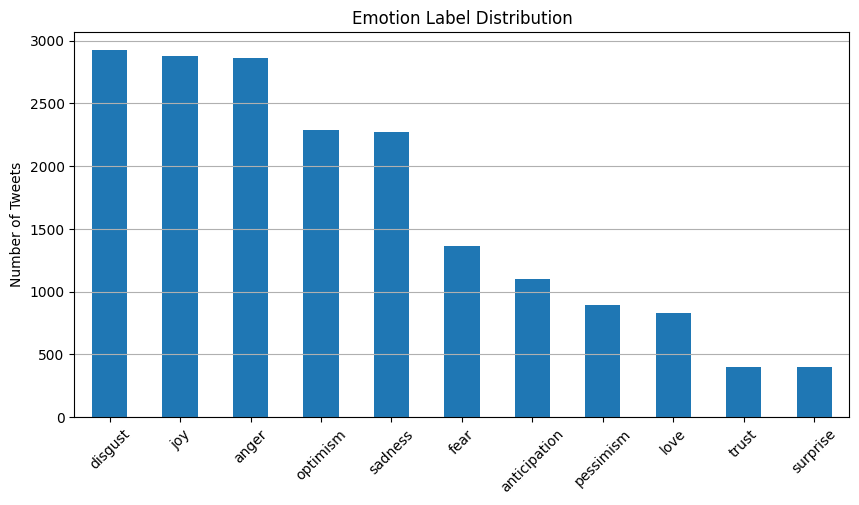


📌 Average number of emotions per tweet: 2.36

💡 Top 5 most common emotion combinations:
anger|disgust            972
joy|optimism             626
anger|disgust|sadness    502
joy|love|optimism        377
joy                      311
Name: count, dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# [1] BASIC DATASET METRICS -----------------------------------
print(f"🧾 Total samples: {len(df)}")
print("\n🔍 Missing values per column:")
print(df.isnull().sum())

# [2] EMOTION LABEL ANALYSIS ---------------------------------
emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Check individual emotion label frequencies
label_counts = df[emotion_cols].sum().sort_values(ascending=False)

# Plot label distribution
plt.figure(figsize=(10,5))
label_counts.plot(kind='bar')
plt.title("Emotion Label Distribution")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# [3] MULTI-LABEL STRUCTURE ANALYSIS --------------------------
# Average number of emotions per tweet
avg_labels = df[emotion_cols].sum(axis=1).mean()
print(f"\n📌 Average number of emotions per tweet: {avg_labels:.2f}")

# Top 5 most common emotion combinations
print("\n💡 Top 5 most common emotion combinations:")
top_combinations = df[emotion_cols].apply(lambda x: '|'.join(x[x==1].index), axis=1)
print(top_combinations.value_counts().head(5))



📊 Multi-label breakdown:
-   218 tweets (2.8%) have 0 emotion labels
-  1099 tweets (14.2%) have 1 emotion labels
-  3124 tweets (40.4%) have 2 emotion labels
-  2404 tweets (31.1%) have 3 emotion labels
-   757 tweets (9.8%) have 4 emotion labels
-   110 tweets (1.4%) have 5 emotion labels
-    12 tweets (0.2%) have 6 emotion labels


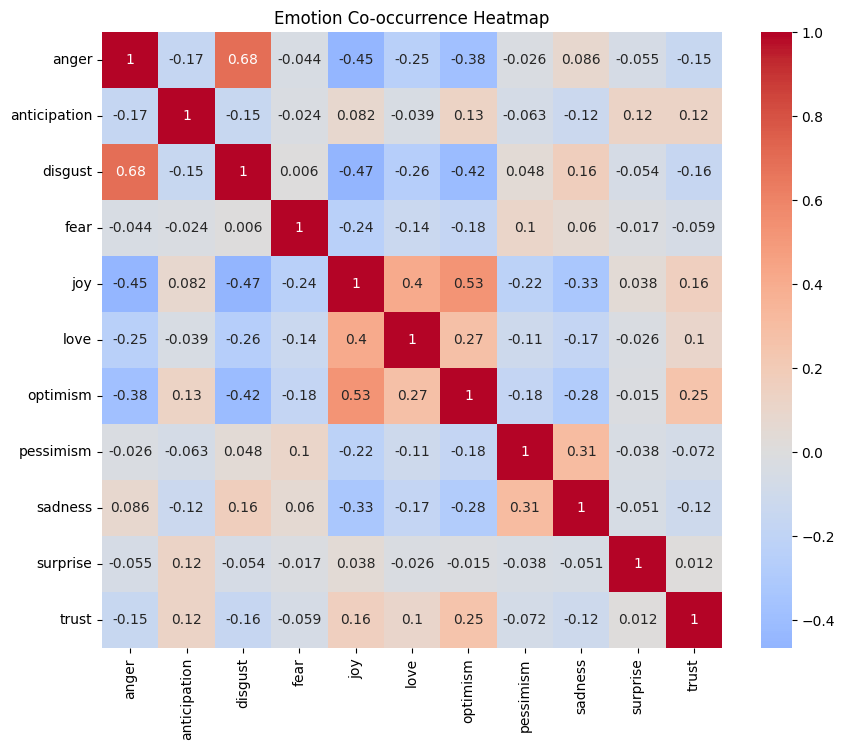

In [ ]:
# [3B] Enhanced Multi-Label Analysis --------------------------
print("\n📊 Multi-label breakdown:")
ml_counts = df[emotion_cols].sum(axis=1).value_counts().sort_index()
for num_labels, count in ml_counts.items():
    print(f"- {count:5} tweets ({count/len(df)*100:.1f}%) have {num_labels} emotion labels")

# Plot label correlation matrix
plt.figure(figsize=(10,8))
sns.heatmap(df[emotion_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title("Emotion Co-occurrence Heatmap")
plt.show()

In [ ]:
# Save locally and log to W&B
heatmap_path = "emotion_heatmap.png"
plt.savefig(heatmap_path, bbox_inches="tight")
wandb.log({"Emotion Heatmap": wandb.Image(heatmap_path)})

plt.show()

<Figure size 640x480 with 0 Axes>


## 1. LABEL DISTRIBUTION  
- Strong class imbalance observed: *disgust*, *joy*, and *anger* are most frequent; *surprise*, *trust*, and *love* are underrepresented  
- ~2.8% of tweets have **no emotion labels** → could be removed or labeled as "neutral"  
- **Action**: Apply `pos_weight` in the loss function or monitor macro F1-score to address imbalance

## 2. MULTI-LABEL STRUCTURE  
- Tweets have an average of **2.36 labels**  
- Frequent label pairs include: `anger|disgust` (972), `joy|optimism` (626)  
- **Action**: Treat as a **multi-label classification task** using `BCEWithLogitsLoss` with **sigmoid activation**

## 3. CO-OCCURRENCE PATTERNS  
- Emotion pairs like `anger+disgust` and `joy+optimism` frequently co-occur  
- **Action**: (Optional) Track performance on frequent emotion combinations for deeper insight


# Insights Summary and Impact on Modeling

**Impact on Next Steps:**

- **Multi-label structure** → Use **sigmoid activation** + **BCEWithLogitsLoss** for training
- **Class imbalance** → Apply **`pos_weight`** in the loss function or monitor **macro F1-score**
- **Clean data** → No major missing data issues; no special handling required
- **Labelless tweets (~2.8%)** → Optional: filter out or label as "neutral"



## Data Processing

- Clean and tokenize text for DistilBERT (first model).

In this section, we clean and tokenize the input text in preparation for training the roberta-base model. Tweets are first preprocessed by removing URLs, mentions, hashtags, and punctuation, and then converted to lowercase. Emotion labels are grouped into binary vectors for multi-label classification. Finally, we tokenize the cleaned text using RoBERTa's tokenizer and convert the data into a Hugging Face Dataset object for training.




In [ ]:
import re
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import RobertaTokenizerFast  # tokenizer for RoBERTa

# ----------------------------------------
# Clean the text

def clean_text(text):
    text = str(text).lower().strip()
    text = re.sub(r"http\S+|@\w+|#\w+", "", text)  # Remove URLs, mentions, hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Optional: remove punctuation
    return text

df["Tweet"] = df["Tweet"].apply(clean_text)  # Apply cleaning to tweet column

# ----------------------------------------
# Prepare labels

emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

df["labels"] = df[emotion_cols].values.tolist()  # Convert label columns into list format

# ----------------------------------------
# Convert to Hugging Face Dataset

dataset = Dataset.from_pandas(df[["Tweet", "labels"]])

# ----------------------------------------
# Tokenization

tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")  # RoBERTa tokenizer

def tokenize(example):
    return tokenizer(example["Tweet"], padding="max_length", truncation=True, max_length=128)

tokenized_dataset = dataset.map(tokenize, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/7724 [00:00<?, ? examples/s]

## Class Imbalance Handling

To address label imbalance in the dataset, we compute a separate weight for each emotion class. These `pos_weight` values reflect the inverse frequency of each class and are used in the loss function to penalize misclassification of underrepresented emotions more heavily. This technique ensures that the model doesn't become biased toward frequent classes.


In [ ]:
import torch

# Define your emotion columns again (if needed)
emotion_cols = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Total number of samples
num_samples = len(df)

# Calculate pos_weight per class: total / (2 * positive_count)
pos_weights = []
for col in emotion_cols:
    positive_count = df[col].sum()
    if positive_count == 0:
        pos_weights.append(1.0)  # fallback to avoid division by zero
    else:
        weight = num_samples / (2 * positive_count)
        pos_weights.append(weight)

# Convert to PyTorch tensor and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float32).to(device)


# Splitting the data

We split the tokenized dataset into **training** and **validation** sets using Hugging Face’s built-in `train_test_split` method. This ensures reproducibility and preserves the tokenized structure, which is necessary for use with Hugging Face's `Trainer`.



In [ ]:
from datasets import DatasetDict

# Split the dataset using Hugging Face's method
split_dataset = tokenized_dataset.train_test_split(
    test_size=0.2,
    shuffle=True,
    seed=42  # For reproducibility
)

# Organize into a DatasetDict
dataset_dict = DatasetDict({
    "train": split_dataset["train"],
    "val": split_dataset["test"]
})

# Optional: verify the structure
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['Tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 6179
    })
    val: Dataset({
        features: ['Tweet', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1545
    })
})



### Configure Training with Class Weights

We load the `roberta-base` model for multi-label classification and configure it to use our custom `BCEWithLogitsLoss` with the previously computed `pos_weights_tensor`. This ensures the model gives appropriate weight to underrepresented emotion classes during training.


In [ ]:
from transformers import RobertaForSequenceClassification  #  RoBERTa version

# Load RoBERTa for multi-label classification
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(emotion_cols),
    problem_type="multi_label_classification"
).to(device)



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define custom weighted loss (multi-label, class imbalance aware)
import torch.nn as nn

def weighted_bce_loss(model, inputs, return_outputs=False):
    labels = inputs["labels"].float()
    inputs["labels"] = labels  # ensure consistency
    outputs = model(**inputs)
    logits = outputs.logits
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)
    loss = loss_fn(logits, labels)
    return (loss, outputs) if return_outputs else loss


from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",       #  monitor macro F1
    greater_is_better=True,                 # higher F1 is better
    logging_steps=50,
    report_to="wandb",
    run_name="exp1-roberta"
)


### Custom Trainer with Weighted Loss

We subclass Hugging Face’s `Trainer` to override the loss function and apply class weights via `BCEWithLogitsLoss`. This helps the model better learn from underrepresented emotion classes.


In [ ]:
from transformers import Trainer

# Custom Trainer to use weighted binary cross-entropy loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):  # accepts extra kwargs
        labels = inputs.pop("labels").float()       # Extract and cast labels
        outputs = model(**inputs)                   # Forward pass
        logits = outputs.logits.float()             # Ensure logits are float32

        loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs > 0.5).astype(int)

    macro_f1 = f1_score(labels, preds, average='macro')
    micro_f1 = f1_score(labels, preds, average='micro')
    return {
        "macro_f1": macro_f1,
        "micro_f1": micro_f1
    }


In [ ]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["val"],
    compute_metrics=compute_metrics
)


In [ ]:
wandb.config.update({
    "model": "roberta-base",
    "learning_rate": training_args.learning_rate,
    "epochs": training_args.num_train_epochs,
    "batch_size": training_args.per_device_train_batch_size,
    "loss_fn": "BCEWithLogitsLoss (weighted)",
    "max_length": 128
})


## Training Job

In [ ]:
%env WANDB_PROJECT=nlp-emotion-classification


env: WANDB_PROJECT=nlp-emotion-classification


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1
1,0.705400,0.686370,0.491661,0.585433
2,0.591600,0.633098,0.530876,0.608175
3,0.524200,0.637853,0.541591,0.613199


TrainOutput(global_step=1161, training_loss=0.6269467979746579, metrics={'train_runtime': 453.5123, 'train_samples_per_second': 40.874, 'train_steps_per_second': 2.56, 'total_flos': 1219420938537216.0, 'train_loss': 0.6269467979746579, 'epoch': 3.0})

# Evaluation & Performance Metrics

In [ ]:
eval_results =trainer.evaluate()

In [ ]:
wandb.log({
    "eval_loss": eval_results["eval_loss"],
    "eval_macro_f1": eval_results.get("macro_f1", None),
    "eval_micro_f1": eval_results.get("micro_f1", None)
})


In [ ]:
print(f"\n📊 Evaluation Metrics:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")



📊 Evaluation Metrics:
eval_loss: 0.6379
eval_macro_f1: 0.5416
eval_micro_f1: 0.6132
eval_runtime: 9.6980
eval_samples_per_second: 159.3110
eval_steps_per_second: 10.0020
epoch: 3.0000


In [ ]:
# Save the fine-tuned RoBERTa model and tokenizer
trainer.save_model("./roberta-emotion")
tokenizer.save_pretrained("./roberta-emotion")


('./roberta-emotion/tokenizer_config.json',
 './roberta-emotion/special_tokens_map.json',
 './roberta-emotion/vocab.json',
 './roberta-emotion/merges.txt',
 './roberta-emotion/added_tokens.json',
 './roberta-emotion/tokenizer.json')

## Generate Kaggle Predictions (DistilBERT)

We are using the fine-tuned DistilBERT model to predict emotion labels for the test tweets. The predicted probabilities are thresholded into binary values and formatted into a submission file matching the competition's required structure.

In [ ]:
# Load and clean test set
test_df = pd.read_csv("/content/drive/My Drive/NLP_CLASS/HOMEWORK/HW5/test.csv")
test_df["Tweet"] = test_df["Tweet"].apply(clean_text)  # Apply same cleaning as train

# Preview the first few rows
test_df.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,dont worry indian army is on its ways to dis...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
1,2018-03739,academy of sciences eschews the normally sober...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
2,2018-00385,i blew that opportunity __,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
3,2018-03001,this time in 2 weeks i will be 30,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
4,2018-01988,is real partners w people truly dont underst...,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [ ]:
# Convert to HF Dataset
test_dataset = Dataset.from_pandas(test_df[["ID", "Tweet"]])

# Tokenize
tokenized_test = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
# Predict
raw_preds = trainer.predict(tokenized_test)
logits = raw_preds.predictions

# Apply sigmoid to get probabilities
probs = torch.sigmoid(torch.tensor(logits))

# Thresholding (multi-label): convert to 0/1
pred_labels = (probs > 0.5).int().numpy()

# Build submission DataFrame
submission = pd.DataFrame(pred_labels, columns=emotion_cols)
submission.insert(0, "ID", test_df["ID"])  # Add ID column at the front


In [ ]:
# Save submission file
submission.to_csv("EXP1_roberta.csv", index=False)



In [ ]:
# Optional: download the submission file
from google.colab import files
files.download("EXP1_roberta.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Final Evaluation Summary – RoBERTa (Exp 1)

**Model:** `roberta-base` (fine-tuned for multi-label emotion classification)

**Training strategy:**  
Used a custom `BCEWithLogitsLoss` with `pos_weight` to handle class imbalance.

---

### Evaluation Metrics:
- **Macro F1 Score:** `0.5416`  
- **Micro F1 Score:** `0.6132`  
- **Validation Loss:** `0.6379`

---

### Runtime & Setup:
- **Training Time:** ~7m34s for 3 epochs  
- **Evaluation Runtime:** `9.70 seconds`  
- **Best Model Saved:** `load_best_model_at_end=True`

---

### Outputs:
- Test predictions saved to: **`EXP1_roberta.csv`**  
- Weights & Biases logging enabled

🔗 **W&B Run:** https://wandb.ai/mourlayetraore120-the-university-of-texas-at-dallas/nlp-emotion-classification?nw=nwusermourlayetraore120
